In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

import time
import os, sys
import torch 

from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import default_cosmology
import lenstronomy.Util.constants as const
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.SimulationAPI.sim_api import SimAPI
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as util
from lenstronomy.LightModel.Profiles.interpolation import Interpol
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from astropy.cosmology import default_cosmology

from scipy import interpolate
from scipy import stats


from sklearn.metrics import mean_squared_error

sys.path.append("../src/models/")
from resnet import ResNetRatioEstimator

# plot formatting 
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

rcnew = {"mathtext.fontset" : "cm", 
         "xtick.labelsize" : 18,
         "ytick.labelsize" : 18,
         "axes.titlesize" : 26, 
         "axes.labelsize" : 22,
         "xtick.major.size" : 8,      # major tick size in points
         "xtick.minor.size" : 4,      # minor tick size in points
         "ytick.major.size" : 8,      # major tick size in points
         "ytick.minor.size" : 4,      # minor tick size in points
         "legend.fontsize" : 22
        }
plt.rcParams.update(rcnew)

%config InlineBackend.figure_format = 'retina'

# from seaborn colorblind palette 
colors = ["#0173B2", "#CC78BC", "#029E73", "#D55E00", "#56B4E9", "#FBAFE4", "#DE8F05", "#CA9161", "#949494", "#ECE133"]

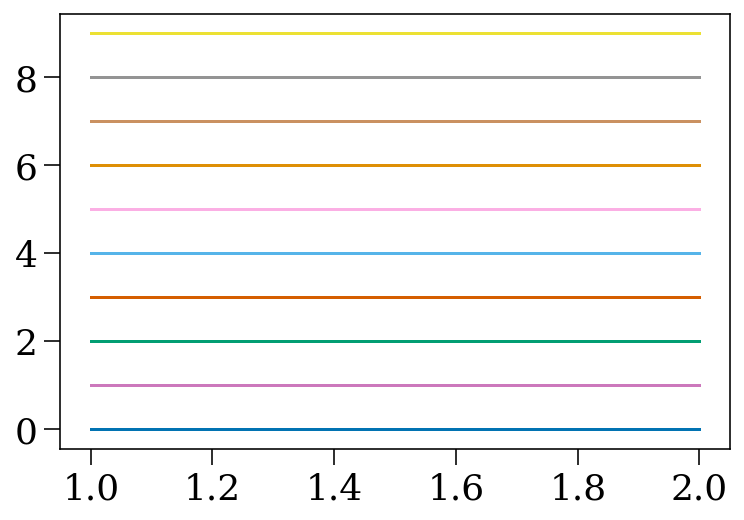

In [2]:
for i in range(len(colors)):
    plt.plot(np.linspace(1,2), i*np.ones(len(np.linspace(1,2))), color=colors[i])

In [3]:
def mass_to_concentration(m):
    '''
    Args: 
        m (float): m200 of NFW subhalo 
    
    Compute concentration following mass-concentration for nfw 
    from https://academic.oup.com/mnras/article/441/4/3359/1209689 at z_lens=0.5
    
    Returns: 
        concentration (float)
    '''
    return 10**(0.814 - 0.086*np.log10(m/(10**12/0.7)))

In [4]:
def to_tensor(x, device=torch.device('cuda:0')): 
    '''
    Args: 
        x (np.array, torch.Tensor): data being sent to gpu 
        device (optional, torch.device): default torch.device('cuda:0'); gpu device for sending x 

    Returns: 
        x (torch.Tensor)
    '''
    if type(x) != torch.Tensor:
        x = torch.from_numpy(x).type(torch.float32).to(device)
    else:
        x = x.type(torch.float32).to(device)
        
    return x 


def load_model(load_dir, epoch, device=torch.device('cuda:0')):
    '''
    Args: 
        load_dir (str): path of model 
        epoch (int): epoch of trained model 
        device (optional, torch.device): default torch.device('cuda:0'); gpu device for sending x
        
    Returns: 
        ResNetRatioEstimator model loaded with load_state_dict
    '''
    checkpoint = torch.load(load_dir + 'epoch%s_checkpt.pth' % epoch)
    args = checkpoint['args']

    if (not hasattr(args, 'cfg')): 
        args.cfg = 18 
        
    model = ResNetRatioEstimator(cfg=args.cfg, n_aux=1, n_out=args.num_features).to(device)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model


def get_predictions(test_data, theta, model, device=torch.device('cuda:0')):
    '''
    Args: 
        test_data (np.array, torch.Tensor): input data into model 
        theta (np.array, torch.Tensor): parameter of interest 
        model (ResNetRatioEstimator): inference model 
        device (optional, torch.device): default torch.device('cuda:0'); gpu device for sending x
        
    Returns: 
        model outputs (np.array) for the given test_data input 
    '''
    with torch.no_grad():
        test_data = to_tensor(test_data)
        theta = to_tensor(theta)
        
        theta = theta.unsqueeze(1)
            
        predictions, logrs = model(test_data, x_aux=theta)
    
    return predictions.cpu().detach().numpy(), logrs.cpu().detach().numpy()



def find_closestvalue_indices(x, value, i_max): 
    '''
    Finds the indices of elements in x that are closest 
    to value on the two sides of x[i_max]; if i_max = 0, len(x)-1, 
    then i_low, i_high = i_max respectively 
    
    Args: 
        x (np.array): has shape (len(x),); array of values 
        value (float)
        i_max (int): index dividing x array into two segments
        
    Returns: 
        i_low, i_high: x[i_low] and x[high] are the nearest to value
                    in x with i_low =< i_max and i_high >= i_max 
    '''
    x_left, x_right = x[:i_max], x[i_max + 1:]
    
    if (len(x_left) == 0): i_low = i_max 
    else: i_low = np.argmin(np.abs(x_left - value))
    
    if (len(x_right) == 0): i_high = i_max 
    else: i_high = np.argmin(np.abs(x_right - value)) + i_max + 1
    
    return i_low, i_high 


def compute_logr(thetas_test, input_test, model, option='lld'): 
    '''
    Args: 
        thetas_test (np.array, torch.Tensor): needs shape (len(thetas_test), 1); array of parameters to be tested 
        input_test (np.array, torch.Tensor): len(thetas_test) = len(input_test)
        model (ResNetRatioEstimator): inference model 
        option (str): allowed options include 'lld' for likelihood logr, 
                    'ref' for reference logr, and 'both' for both logrs
                    
    Returns: 
        logrs: log likelihood-ratios (torch.Tensor of shape (len(logrs),)) from 
                putting input_test and thetas_test into model 
    '''
    
    assert option == 'lld' or option == 'ref' or option == 'both'
    
    with torch.no_grad():
        thetas_test = to_tensor(thetas_test)
        input_test = to_tensor(input_test)
        
        if (option == 'lld'): 
            _, logrs = model(input_test, x_aux=thetas_test, train=False)
        elif (option == 'ref'):
            _, logrs = model(input_test, x_aux=thetas_test, train=True)
            logrs = logrs[1::2]
        else: 
            _, logrs = model(input_test, x_aux=thetas_test, train=True)
        
    return logrs.flatten()


def get_errors(logrs, targets_test, inds_max, option='both'): 
    '''
    Args: 
        logrs (ndarray): log llr matrix (shape: (len(targets_test), number of samples = len(inds_max))) 
        targets_test (array): a list of values being tested for llr 
        inds_max (array): indices at which the llr is max for all samples 
        option (str): default "both"; options are "low", "high" and "both"
    
    Return: 
        errlow (np.array): lowerbound errors on llr (if option="low" or "both") otherwise empty 
        errhigh (np.array): upperbound errors on llr (if option="high" or "both") otherwise empty
    '''
    
    assert option == 'both' or option == 'low' or option == 'high'
    
    targets_errlow = [] 
    targets_errhigh = [] 

    if (option == 'both'): 
        for i, ind_max in enumerate(inds_max): 
            i_low, i_high = find_closestvalue_indices(-2*logrs[:, i], stats.chi2.isf(0.32, df=1), ind_max)
            
            targets_errlow.append(targets_test[i_low])
            targets_errhigh.append(targets_test[i_high])
    elif (option == 'low'): 
        for i, ind_max in enumerate(inds_max): 
            if (len(logrs[:ind_max, i]) == 0): i_low = ind_max 
            else: i_low = np.argmin(np.abs(logrs[:ind_max, i] + stats.chi2.isf(0.32, df=1)/2))
            targets_errlow.append(targets_test[i_low])
    else: 
        for i, ind_max in enumerate(inds_max): 
            if (len(logrs[ind_max+1:, i]) == 0): i_high = 0 
            else: i_high = np.argmin(np.abs(logrs[ind_max+1:, i] + stats.chi2.isf(0.32, df=1)/2))
            targets_errhigh.append(targets_test[ind_max+1+i_high])

    return np.array(targets_errlow), np.array(targets_errhigh)



def get_logrs(theta_test, data_test, model):
    '''
    Args: 
        thetas_test (np.array, torch.Tensor): array of parameters to be tested 
        data_test (np.array, torch.Tensor): the images to test thetas_test with 
        model (ResNetRatioEstimator): inference model 
        
    Returns: 
        logrs (np.array): array of llrs corresponding to theta_test array with each 
            column corresponding to one image
    '''
    
    if (len(np.shape(data_test)) == 2): data_test = [data_test]
        
    logrs = [] 
    
    for theta in theta_test: 
        logr = compute_logr(theta*np.ones((len(data_test), 1)), data_test, model)

        logrs.append(logr.cpu().detach().numpy())

    logrs = np.array(logrs)

    return logrs 

    
def get_maxlogrs(logrs): 
    '''
    Args: 
        logrs (ndarray): matrix of logrs, each column corresponding to one logr distribution of a sample 
        
    Returns: 
        inds_max (np.array): indices in each column of logrs that give the max logr in the column 
        logrs_max (np.array): max logrs in each column 
    '''
    
    # get the values that give the highest likelihood for each sample 
    inds_max = np.argmax(logrs, axis=0).T
    logrs_max = np.amax(logrs, axis=0).T
    
    return inds_max, logrs_max 


def plot_predictions(model, thetas_test, thetas_exp, thetas_mean, data_test, color, error=None, label=''):
    '''
    Args:
        model (ResNetRatioEstimator): inference model 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_exp (list-like): expected thetas corresponding to sample in data_test; len(thetas_exp) = len(data_test)
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        data_test (np.array): array of input data 
        color (str): color of scatter plot 
        error (str): default None; options are 'both', 'low', 'high'
        label (str): default empty string; label for scatter plot
        
    Returns: 
        predicted thetas corresponding to data_test, theta low errors (if option='low' or 'both') otherwise [], 
        theta high errors (if option='high' or 'both') otherwise [] 
        
    Side effect: 
        show the scatter plot 
    '''

    start_time = time.time()

    logrs = get_logrs(thetas_test - thetas_mean, data_test, model) 
        
    maxinds, maxlogrs = get_maxlogrs(logrs)
    logrs = logrs - maxlogrs  # adjust so peak is at 0 
    
    thetas_pred = thetas_test[maxinds]   # get predicted values 

    print("--- %s seconds ---" % (time.time() - start_time))
    
    if error: 
        thetas_errlow, thetas_errhigh = get_errors(logrs, thetas_test, maxinds, option=error)

    plt.scatter(thetas_exp, thetas_pred, s=8, color=color, label=label, alpha=0.5)
    
    if error: 
        if (error == 'both'): 
            plt.errorbar(thetas_exp, thetas_pred, [thetas_pred-thetas_errlow, thetas_errhigh-thetas_pred], fmt='none', color=color, alpha=0.5, capsize=3)
        elif (error == 'low'): 
            plt.errorbar(thetas_exp, thetas_pred, [thetas_pred-thetas_errlow, thetas_pred-thetas_errlow], fmt='none', color=color, alpha=0.5, capsize=3)
        else: 
            plt.errorbar(thetas_exp, thetas_pred, [thetas_errhigh-thetas_pred, thetas_errhigh-thetas_pred], fmt='none', color=color, alpha=0.5, capsize=3)
        return thetas_pred, thetas_errlow, thetas_errhigh
    else: 
        return thetas_pred, [], []

In [5]:
def get_combined_predictions(model, paths, n_comb, thetas_test, thetas_mean, data_mean, data_std):
    '''
    Args: 
        model (ResNetRatioEstimator): inference model 
        paths (list of str): paths to the images (each including one {} for image number)
        n_comb (int): number of images to combine 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        data_mean (float): mean of training set data; used for whitening test data 
        data_std (float): std of training set data; used for whitening test data 
        
    Returns: 
        predicted mle thetas corresponding to data_test, theta 1sig errors below, theta 1sig errors above,
        theta 2sig errors below, theta 2sig errors above (all np.array)
    '''
    
    gs_pred = [] 
    gs_1sig_low, gs_1sig_high = [], []
    gs_2sig_low, gs_2sig_high = [], []

    for p in paths: 
        data_comb = [np.load(p.format(i + 1)) for i in range(n_comb)]

        data_comb = (np.array(data_comb) - data_mean)/data_std

        logrs_comb = get_logrs(thetas_test - thetas_mean, data_comb, model)

        logr_comb = np.mean(logrs_comb, axis=1) 
        logr_comb -= np.max(logr_comb)  # adjust so the peak is at 0 

        i_low, i_high = find_closestvalue_indices(-2*logr_comb, stats.chi2.isf(0.32, df=1)/len(data_comb), np.argmax(logr_comb))
        i_low_2sig, i_high_2sig = find_closestvalue_indices(-2*logr_comb, stats.chi2.isf(0.05, df=1)/len(data_comb), np.argmax(logr_comb))

        gs_pred.append(thetas_test[np.argmax(logr_comb)]) 
        gs_1sig_low.append(thetas_test[i_low])
        gs_1sig_high.append(thetas_test[i_high])
        gs_2sig_low.append(thetas_test[i_low_2sig])
        gs_2sig_high.append(thetas_test[i_high_2sig])

    return np.array(gs_pred), np.array(gs_1sig_low), np.array(gs_1sig_high), np.array(gs_2sig_low), np.array(gs_2sig_high)


def load_data(path_train, path_val, n_data): 
    '''
    Args: 
        path_train (str): path to load training set info 
        path_val (str): path to load validation set info 
        n_data (int): number of data points in training set 
    
    Returns: 
        training set gammas (np.array), validation set gammas (np.array), training set gamma mean (float), 
        training set data mean (float), training set data std (float)
    '''
    
    gammas_train = np.load(path_train + 'gammas_all.npy')
    gammas_val = np.load(path_val + 'gammas_all.npy')

    gammas_mean = np.mean(gammas_train, axis=0)

    data_mean = np.load(path_train + 'im_mean_{}.npy'.format(n_data))
    data_std = np.load(path_train + 'im_std_{}.npy'.format(n_data))
    
    return gammas_train, gammas_val, gammas_mean, data_mean, data_std 


def load_epochlosses(path_model, n_data, bs): 
    '''
    Args: 
        path_model (str): path where the model info is saved 
        n_data (int): number of data points in training set 
        bs (int): batch size 
    
    Returns: 
        epoch train losses (np.array), epoch validation losses (np.array), max trained epoch (int)
    '''
    
    trainlosses = np.load(path_model + 'arrays/train_losses.npy')
    vallosses = np.load(path_model + 'arrays/val_losses.npy')

    trainlosses_epoch = np.mean(trainlosses.reshape(-1, int(n_data)//bs), axis=1)
    vallosses_epoch = np.mean(vallosses.reshape(-1, int(n_data)//bs), axis=1)
    
    return trainlosses_epoch, vallosses_epoch, len(trainlosses_epoch) 

In [6]:
def kappabar_nfw(x, rs, rs_angle): 
    '''
    Args: 
        x (np.array): array of radial distances 
        rs (float): scale radius 
        rs_angle (float): deflection angle at scale radius 
    
    Returns: 
        analytical kappabar at distances specified by x 
    '''
    rho0 = rs_angle / (4. * rs ** 2 * (1. + np.log(1. / 2.)))
    return NFW.mass_2d(NFW(), x, rs, rho0)/np.pi/x**2


def get_Lmatrix(xdotI_matrix, xs_radial, kernel, deltapix): 
    '''
    follows eq. 7 of https://arxiv.org/pdf/2206.10635v2.pdf
    
    Args: 
        xdotI_matrix (list-like): x dot grad I at every pixel of image; len(xdotI_matrix)=numPix^2 
        xs_radial (list-like): radial distances from every pixel to the center of subhalo; len(xs_radial)=numPix^2 
        kernel (ndarray): psf kernel used for image generation; side length has to be odd 
        deltapix (float): pixel size resolution in arcsec 
        
    Returns: 
        L matrix 
    '''
    size_kernel = len(kernel)   # needs to be odd 
    assert size_kernel % 2 == 1, "kernel size needs to be odd!"
    
    numPix = int(np.sqrt(len(xdotI_matrix)))
    
    n_pad = (size_kernel - 1)//2
    xdotI_matrix_padded = np.pad(np.reshape(xdotI_matrix, (numPix, numPix)), ((n_pad, n_pad), (n_pad, n_pad)))
    xs_radial_padded = np.pad(np.reshape(xs_radial, (numPix, numPix)), ((n_pad, n_pad), (n_pad, n_pad)))

    # make empty matrix for L 
    L_matrix = []

    # for each pixel at (i, j) 
    for i in range(numPix): 
        for j in range(numPix): 
            # select the (k, l) values that contribute to (i, j) based on convolution kernel size and their binned class # 
            matrix_kl_contrib = xdotI_matrix_padded[i:i+size_kernel, j:j+size_kernel]

            # compute the matrix of convolved x dot grad I value for these (k, l) pixels 
            convolvedprod = -np.multiply(matrix_kl_contrib, kernel)

            # use the binned class to add contribution to the given bin 
            xs_radial_temp = xs_radial_padded[i:i+size_kernel, j:j+size_kernel]

            # filter values in matrix corresponding to each bin and append the sum to array 
            L_ij,_,_ = stats.binned_statistic(xs_radial_temp.flatten(), convolvedprod.flatten(), statistic='sum', bins=r_bins)

            # append array to matrix 
            L_matrix.append(L_ij)
            
    return np.array(L_matrix)*deltapix**2


def avg_densityslope(xs, rs, rs_angle):
    '''
    Args: 
        xs (np.array): array of radial distances 
        rs (float): scale radius 
        rs_angle (float): deflection angle at scale radius 
    
    Returns: 
        average nfw density slope in the radial range given by xs (float)
    '''
    logkappabars = np.log10(kappabar_nfw(xs, rs, rs_angle))
    slopes_xs = 1 - (logkappabars[1:] - logkappabars[:-1])/(np.log10(xs[1:]) - np.log10(xs[:-1]))
    slope_bestfit = np.mean(slopes_xs)
    
    return slope_bestfit


def compute_rmo_range(r_bins, sig_rel_rbins, rmo_threshold, nbin_rmo=51): 
    '''
    Args:
        r_bins (list-like): radial distances from subhalo center 
        sig_rel_rbins (list-like): relative uncertainties on kappabar corresponding to r_bins 
        rmo_threshold (float): rmo determined based on sig_rel_rbins < rmo_threshold*np.min(sig_rel_rbins)
        nbin_rmo (int): default 51; number of bins in RMO radial distances being returned 
    
    Returns: 
        radial distances evenly spaced on the RMO with nbin_rmo bins (np.array)
    '''
    # select region with relative error less than twice of smallest relative error 
    idx_rmo = np.where(sig_rel_rbins < rmo_threshold*np.min(sig_rel_rbins))
    r_rmo_low, r_rmo_high = r_bins[np.min(idx_rmo)], r_bins[np.max(idx_rmo) + 1]

    rs_rmo = np.linspace(r_rmo_low, r_rmo_high, num=nbin_rmo)
    
    return rs_rmo


def get_kappabars_and_errors(args_subhalo, r_ctrs, x_grid, y_grid, C_inv, kernel, deltapix): 
    '''
    follows eq. 7-8 of https://arxiv.org/pdf/2206.10635v2.pdf
    
    Args: 
        args_subhalo (dict): args specify subhalo properties 
        r_ctrs (np.array): radial distances at which to compute kappabars 
        x_grid (np.array): x positions of all pixels 
        y_grid (np.array): y positions of all pixels 
        C_inv (ndarray): inverse covariance matrix 
        kernel (ndarray): psf kernel used for image generation; side length has to be odd 
        deltapix (float): pixel size resolution in arcsec 
    
    Returns: 
        kappabar corresponding to r_ctrs (np.array), uncertainties on kappabar (np.array), m200 of subhalo
    
    '''
   
    # take args of single subhalo
    cx, cy  = args_subhalo['center_x'], args_subhalo['center_y'] 
    rs, rs_angle = args_subhalo['Rs'], args_subhalo['alpha_Rs']
    
    _,_,_,_,msub = lensCosmo.nfw_angle2physical(rs, rs_angle)
        
    # get analytical kappabar in each r bin 
    kappabars_rctr = kappabar_nfw(r_ctrs, rs, rs_angle)
    
    # for each (k, l) pair (following x_grid and y_grid)
    # compute matrix of x dot grad I for the pixel 
    xx, xy = x_grid - cx, y_grid - cy
    xdotI_matrix = np.sum(np.multiply(grad_I, [xx, xy]), axis=0)

    # compute radial distance at (k, l) positions 
    xs_radial = np.sqrt(xx**2 + xy**2)

    # get L matrix and then the error: http://arxiv.org/abs/2206.10635 eq 7-8 
    L_matrix = get_Lmatrix(xdotI_matrix, xs_radial, kernel, deltapix) 
    A_matrix = np.dot(np.dot(L_matrix.T, C_inv), L_matrix)
    sig_rctr = np.sqrt(np.diag(np.linalg.pinv(A_matrix))) 

    return kappabars_rctr, sig_rctr, msub 

In [7]:
PATH_7to10 = '/n/holyscratch01/dvorkin_lab/gzhang/Storage/SL_images/deltapix0.08_numpix100_eplsh_logm7.0to10.0_beta-1.9_nsub0to500_0.5maxpix_g1.1to2.9_gammaw0.1_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/'
PATH_data_7to10 = PATH_7to10 + 'val/deltapix0.08_numpix100_eplsh_logm7.0to10.0_beta-1.9_nsub0to500_0.5maxpix_g1.1to2.9_gammaw0.1_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/'
PATH_model_7to10 = PATH_7to10 + 'models/resratio18gamma_AdamW_dout0.0_lr0.001_bs2000_ndata500000/'

PATH_8to10 = '/n/holyscratch01/dvorkin_lab/gzhang/Storage/SL_images/deltapix0.08_numpix100_eplsh_logm8.0to10.0_beta-1.9_nsub0to60_0.5maxpix_g1.1to2.9_gammaw0.1_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/'
PATH_data_8to10 = PATH_8to10 + 'val/deltapix0.08_numpix100_eplsh_logm8.0to10.0_beta-1.9_nsub0to60_0.5maxpix_g1.1to2.9_gammaw0.1_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/'
PATH_model_8to10 = PATH_8to10 + 'models/resratio18gamma_AdamW_dout0.0_lr0.001_bs2000_ndata500000/'

PATH_logm9 = '/n/holyscratch01/dvorkin_lab/gzhang/Storage/SL_images/deltapix0.08_numpix100_eplsh_logm9.0to9.0_beta-1.9_nsub0to100_0.5maxpix_g1.1to2.9_gammaw0.1_zl0.5zs1.0_nms_noise10orb_varycosmos_shear0.1/'
PATH_data_logm9 = PATH_logm9 + 'val/deltapix0.08_numpix100_eplsh_logm9.0to9.0_beta-1.9_nsub0to100_0.5maxpix_g1.1to2.9_gammaw0.1_zl0.5zs1.0_nms_noise10orb_varycosmos_shear0.1/'
PATH_model_logm9 = PATH_logm9 + 'models/resratio18gamma_AdamW_dout0.0_lr0.001_bs2000_ndata500000/'

n_data = 500000
bs = 2000

# linearly spaced array in gamma to test likelihoods on 
gammas_test = np.linspace(1, 3, 201)

In [8]:
# get the saved training mean and std for whitening test data 
_, gs_val_7to10, g_mean_7to10, mean_7to10, std_7to10 = load_data(PATH_7to10, PATH_data_7to10, n_data)
_,_, g_mean_8to10, mean_8to10, std_8to10 = load_data(PATH_8to10, PATH_data_8to10, n_data)
_,_, g_mean_logm9, mean_logm9, std_logm9 = load_data(PATH_logm9, PATH_data_logm9, n_data)

In [9]:
model_7to10 = load_model(PATH_model_7to10 + 'arrays/', epoch=29)
model_7to10.eval()

model_8to10 = load_model(PATH_model_8to10 + 'arrays/', epoch=30)
model_8to10.eval()

model_logm9 = load_model(PATH_model_logm9 + 'arrays/', epoch=20)
model_logm9.eval()

ResNetRatioEstimator(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [10]:
n_test = 100
data_val_7to10 = [np.load(PATH_data_7to10 + 'images/SLimage_{}.npy'.format(i+1)) for i in range(n_test)]
data_val_7to10 = (np.array(data_val_7to10) - mean_7to10)/std_7to10

--- 1.887650728225708 seconds ---


(1.0, 3.0)

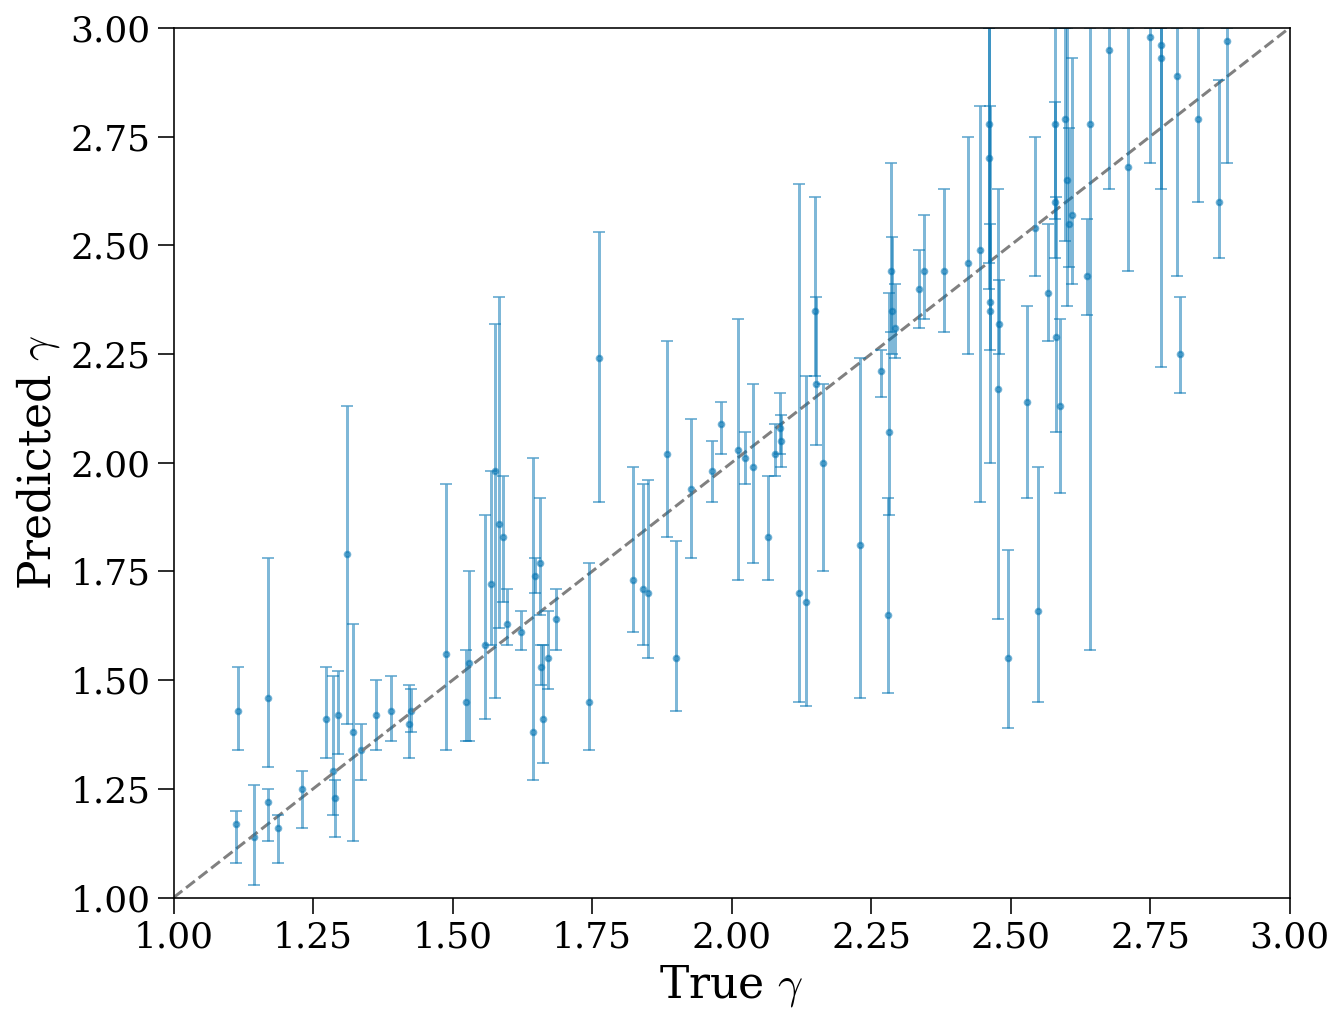

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(gammas_test, gammas_test, color='gray', linestyle='--')
plot_predictions(model_7to10, gammas_test, gs_val_7to10[:n_test], g_mean_7to10, data_val_7to10, colors[0], error='both')
plt.xlabel(r'True $\gamma$')
plt.ylabel(r'Predicted $\gamma$')
plt.ylim(1, 3)
plt.xlim(1, 3)

#plt.savefig('../data/resnet_valgamma_scatter_{}_shear.pdf'.format(n_test))

In [12]:
n_gt = 10
gts = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9]

paths_epl = [PATH_7to10 + 'test_g{}/deltapix0.08_numpix100_eplsh_logm7.0to10.0_beta-1.9_nsub0to500_0.5maxpix_g1.5to2.5_gammaw0.1_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/images/SLimage_{}.npy'.format(g, '{}') for g in gts]


In [13]:
gs_pred_epl, gs_1sig_low_epl, gs_1sig_high_epl, gs_2sig_low_epl, gs_2sig_high_epl = get_combined_predictions(model_7to10, paths_epl, n_gt, gammas_test, g_mean_7to10, mean_7to10, std_7to10)


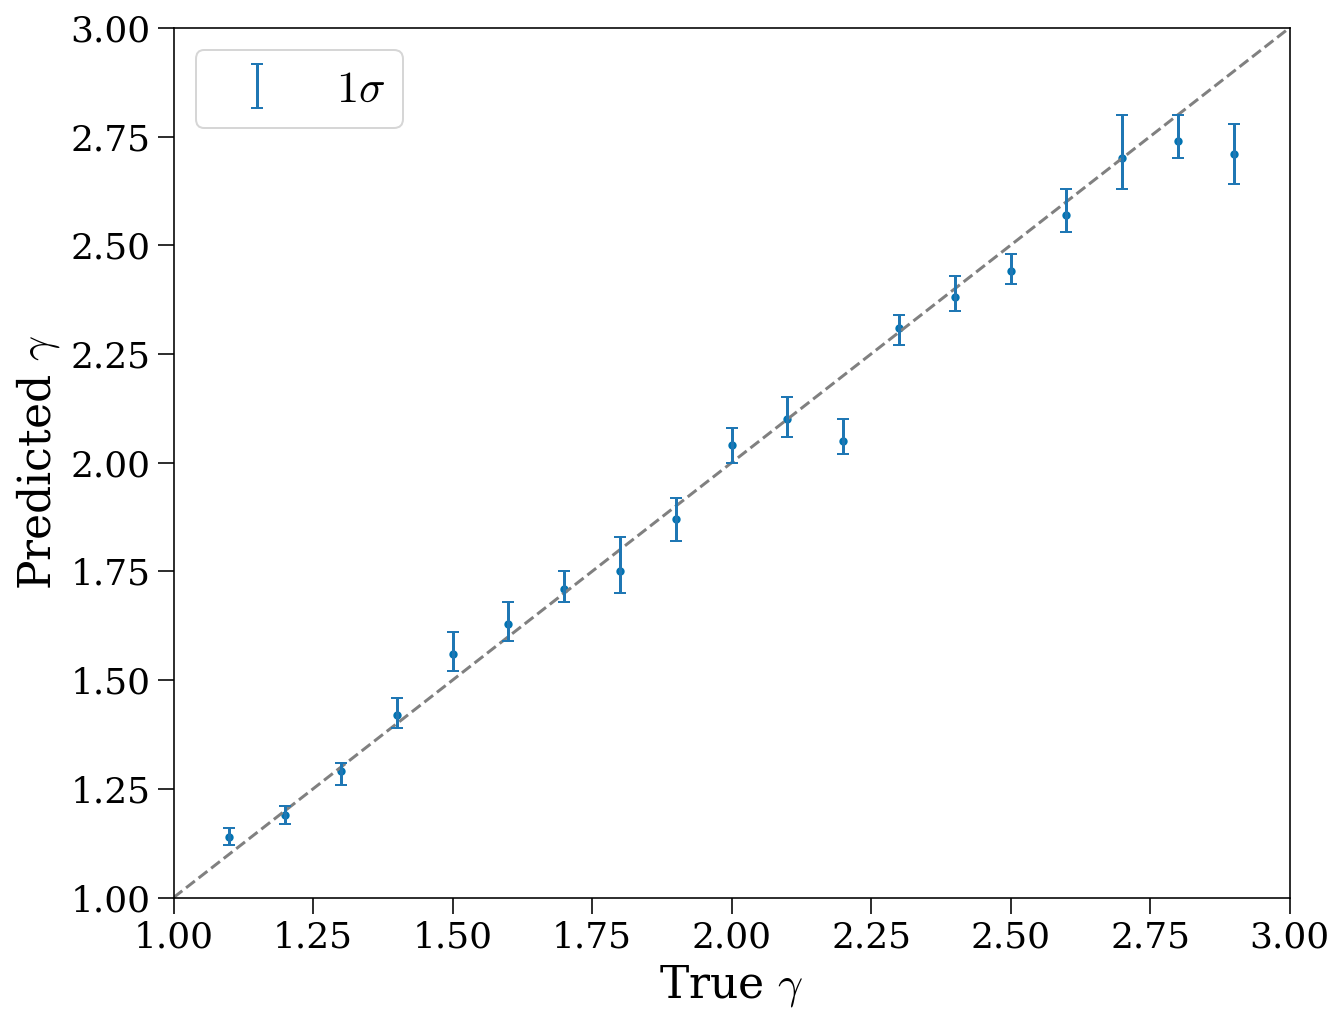

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(gammas_test, gammas_test, color='gray', linestyle='--')
plt.scatter(gts, gs_pred_epl, color=colors[0], s=10)
plt.errorbar(gts, gs_pred_epl, [gs_pred_epl-gs_1sig_low_epl, gs_1sig_high_epl-gs_pred_epl], fmt='none', capsize=3, label=r'$1\sigma$')
plt.xlabel(r'True $\gamma$')
plt.ylabel(r'Predicted $\gamma$')
plt.ylim(1, 3)
plt.xlim(1, 3)
plt.legend()

#plt.savefig('../data/resnet_combine{}epl_shear.pdf'.format(n_gt))

In [15]:
nfw_cfactors_str = np.array(['0.2', '0.4', '0.6', '0.8', '1', '2', '4', '6', '8', '10']) 
nfw_cfactors = nfw_cfactors_str.astype(np.float)

In [16]:
paths_nfw_7to10 = [PATH_7to10 + 'test_nfw{}/deltapix0.08_numpix100_NFWsh_logm7.0to10.0_beta-1.9_nsub0to500_0.5maxpix_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/images/SLimage_{}.npy'.format(cfac, '{}') for cfac in nfw_cfactors_str]
paths_nfw_8to10 = [PATH_8to10 + 'test_nfw{}/deltapix0.08_numpix100_NFWsh_logm8.0to10.0_beta-1.9_nsub0to60_0.5maxpix_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/images/SLimage_{}.npy'.format(cfac, '{}') for cfac in nfw_cfactors_str]
paths_nfw_logm9 = [PATH_logm9 + 'test_nfw{}/deltapix0.08_numpix100_NFWsh_logm9.0to9.0_beta-1.9_nsub0to100_0.5maxpix_zl0.5zs1.0_nms_noise10orb_varycosmos_shear0.1/images/SLimage_{}.npy'.format(cfac, '{}') for cfac in nfw_cfactors_str]


In [17]:
n_c = 50

gs_pred_7to10, gs_1sig_low_7to10, gs_1sig_high_7to10, gs_2sig_low_7to10, gs_2sig_high_7to10 = get_combined_predictions(model_7to10, paths_nfw_7to10, n_c, gammas_test, g_mean_7to10, mean_7to10, std_7to10)
gs_pred_8to10, gs_1sig_low_8to10, gs_1sig_high_8to10, gs_2sig_low_8to10, gs_2sig_high_8to10 = get_combined_predictions(model_8to10, paths_nfw_8to10, n_c, gammas_test, g_mean_8to10, mean_8to10, std_8to10)
gs_pred_logm9, gs_1sig_low_logm9, gs_1sig_high_logm9, gs_2sig_low_logm9, gs_2sig_high_logm9 = get_combined_predictions(model_logm9, paths_nfw_logm9, n_c, gammas_test, g_mean_logm9, mean_logm9, std_logm9)


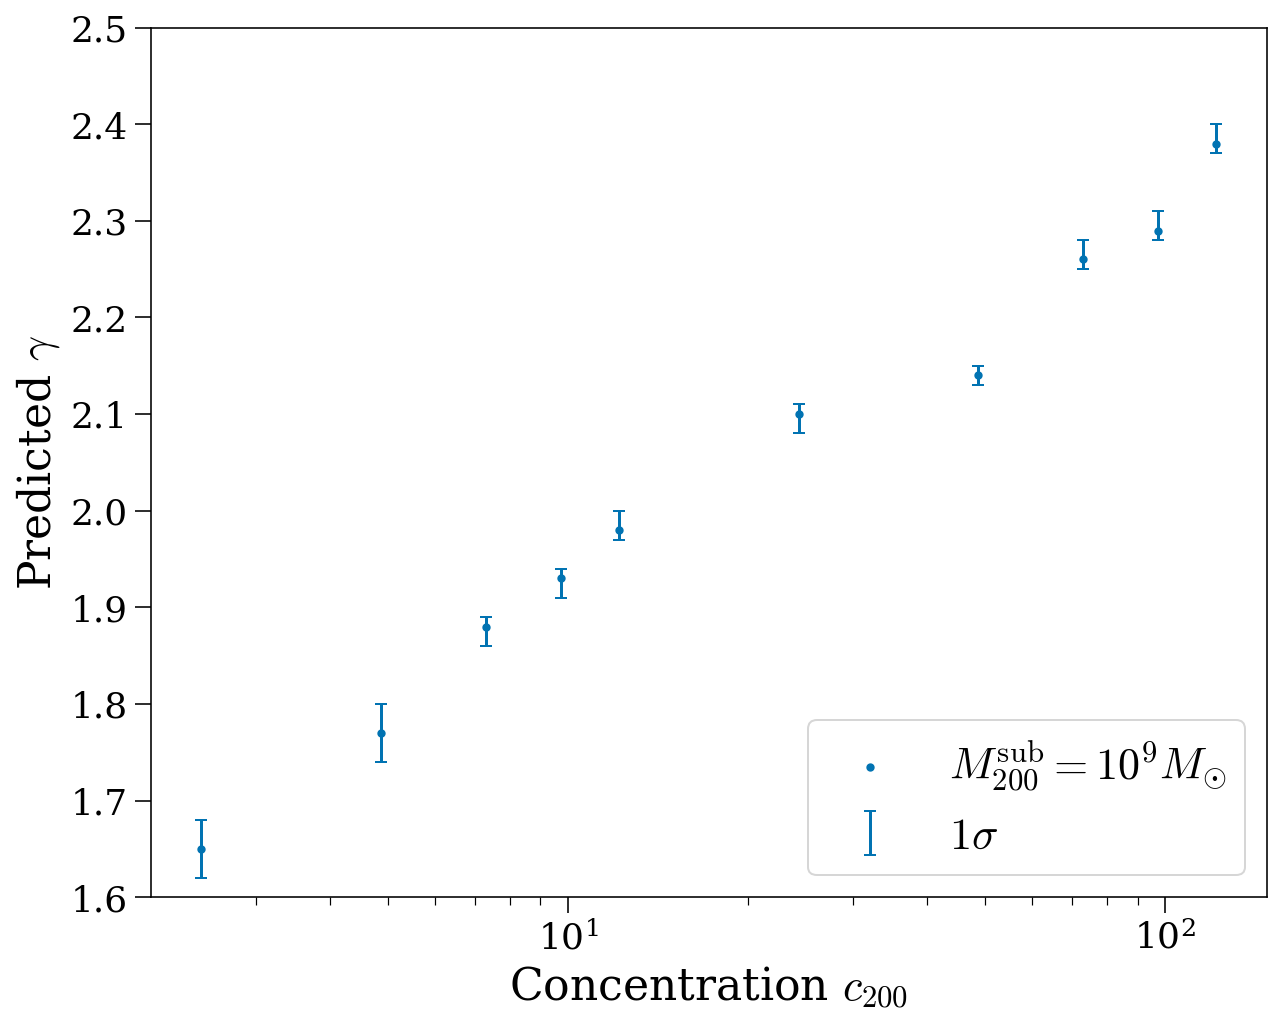

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(nfw_cfactors*mass_to_concentration(1e9), gs_pred_logm9, color=colors[0], label=r'$M_{200}^{\mathrm{sub}} = 10^9 M_{\odot}$', s=10)
ax.errorbar(nfw_cfactors*mass_to_concentration(1e9), gs_pred_logm9, [gs_pred_logm9-gs_1sig_low_logm9, gs_1sig_high_logm9-gs_pred_logm9], fmt='none', capsize=3, label=r'$1 \sigma$', color=colors[0])

ax.set_xlabel(r'Concentration $c_{200}$')
ax.set_ylabel(r'Predicted $\gamma$') 
ax.set_ylim(1.6, 2.5)
ax.set_xscale("log")
ax.legend(loc='lower right')

#plt.savefig('../data/msub1e9nfw_combine{}_shear.pdf'.format(n_c))

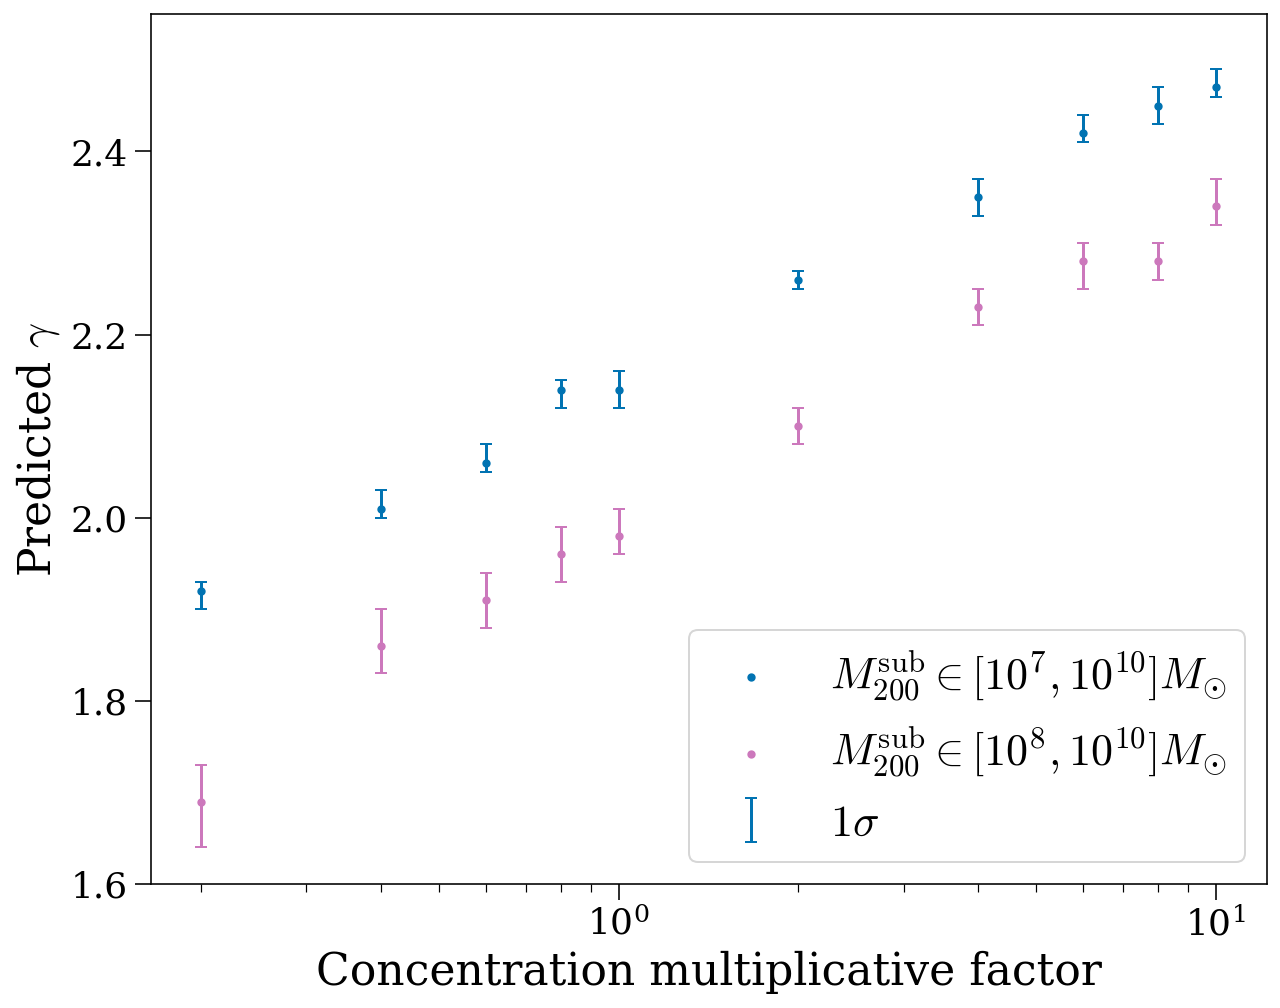

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

p1 = ax.scatter(nfw_cfactors, gs_pred_7to10, color=colors[0], label=r'$M_{200}^{\mathrm{sub}} \in [10^7, 10^{10}] M_{\odot}$', s=10)
p2 = ax.scatter(nfw_cfactors, gs_pred_8to10, color=colors[1], label=r'$M_{200}^{\mathrm{sub}} \in [10^8, 10^{10}] M_{\odot}$', s=10)

ax.errorbar(nfw_cfactors, gs_pred_7to10, [gs_pred_7to10-gs_1sig_low_7to10, gs_1sig_high_7to10-gs_pred_7to10], color=colors[0], fmt='none', capsize=3, label=r'$1 \sigma$')
ax.errorbar(nfw_cfactors, gs_pred_8to10, [gs_pred_8to10-gs_1sig_low_8to10, gs_1sig_high_8to10-gs_pred_8to10], color=colors[1], fmt='none', capsize=3)

ax.set_xlabel('Concentration multiplicative factor')
ax.set_ylabel(r'Predicted $\gamma$') 
ax.set_ylim(1.6, 2.55)
ax.set_xscale("log")

ax.legend(loc='lower right')

#plt.savefig('../data/compare_7to10_8to10_combine{}_shear.pdf'.format(n_c))

In [20]:
# load info for a single image
PATH_single = PATH_7to10 + 'test_nfw1/deltapix0.08_numpix100_NFWsh_logm7.0to10.0_beta-1.9_nsub0to500_0.5maxpix_zl0.5zs1.0_noise10orb_varycosmos_shear0.1/'
i_single = 79 # starts at 0 

sourcearg = np.load(PATH_single + 'sourceargs/sourcearg_{}.npy'.format(i_single + 1), allow_pickle=True)
lensarg = np.load(PATH_single + 'lensargs/lensarg_{}.npy'.format(i_single + 1), allow_pickle=True)
modelarg = np.load(PATH_single + 'modelargs/modelarg_{}.npy'.format(i_single + 1), allow_pickle=True).item()

nsub = len(lensarg) - 2
im_single = np.load(PATH_single + 'images/SLimage_{}.npy'.format(i_single + 1))
print(nsub)

388


In [21]:
# get model predictions on the image
logps_single = get_logrs(gammas_test-g_mean_7to10, np.array([im_single]), model_7to10)

In [22]:
# set up cosmo info 
cosmo = default_cosmology.get()
z_lens, z_source = modelarg['z_lens'], modelarg['z_source']
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# # lenstronomy default range is not enough: linspace(0.1, 10)
# https://lenstronomy.readthedocs.io/en/stable/_modules/lenstronomy/Cosmo/nfw_param.html#NFWParam
from scipy import interpolate
c_array = np.linspace(0.1, 30, num=500)   
lensCosmo.nfw_param._c_rho0_interp = interpolate.InterpolatedUnivariateSpline(lensCosmo.nfw_param.rho0_c(c_array, z_lens), c_array, w=None, bbox=[None, None], k=3)

In [23]:
# make image with noise 
deltapix, numPix = 0.08, 100 

hst = HST(band='WFC3_F160W', psf_type='GAUSSIAN')
norbits = hst.kwargs_single_band()
norbits['pixel_scale'] = deltapix
norbits['seeing'] = deltapix
norbits['exposure_time'] = 5400 * 10  # each orbit is 5400 secs 

Hub = SimAPI(numpix=numPix,
             kwargs_single_band=norbits,
             kwargs_model=modelarg
            )

hb_im = Hub.image_model_class(kwargs_numerics = {'point_source_supersampling_factor': 1})

im_nonoise = hb_im.image(kwargs_lens=lensarg, kwargs_source=sourcearg)
noise = Hub.noise_for_model(im_nonoise)
im = im_nonoise + noise

In [24]:
# get the psf kernel 
psf_temp = Hub.psf_class
psf_temp.set_pixel_size(deltapix)

kernel = psf_temp.kernel_point_source

# get noise and C matrix 
sigma_bkg = Hub.background_noise
exp_time = Hub.exposure_time
C_inv2 = np.diag(1/(np.abs(im_nonoise)/exp_time + sigma_bkg**2).flatten())
C_inv = np.diag(1/(Hub.estimate_noise(im_nonoise)**2).flatten()) 

In [25]:
# gradient on the source image 
x_grid, y_grid = util.make_grid(numPix=numPix, deltapix=deltapix)

numPix_source = numPix*4
deltapix_source = deltapix/2
x_grid_source, y_grid_source = util.make_grid(numPix=numPix_source, deltapix=deltapix_source)

# get flux 
flux = Interpol.function(Interpol(), x_grid_source, y_grid_source, **sourcearg[0]).reshape(numPix_source, numPix_source)

# get gradients of source flux 
grad_source = np.gradient(flux, deltapix_source)

# .T needed because of the convention of RectBivariateSpline 
# otherwise have to flip x and y during interpolation 
grad_source_interpx = interpolate.RectBivariateSpline(x_grid_source[:numPix_source], x_grid_source[:numPix_source], grad_source[1].T)
grad_source_interpy = interpolate.RectBivariateSpline(x_grid_source[:numPix_source], x_grid_source[:numPix_source], grad_source[0].T)

# gradient of source 
yx, yy = LensModel([modelarg['lens_model_list'][0]]).ray_shooting(x_grid, y_grid, [lensarg[0]])  # position in source plane
grad_I = grad_source_interpx(yx, yy, grid=False), grad_source_interpy(yx, yy, grid=False)


In [26]:
# make bins radial distance and thus in kappabar 
r_bins = np.linspace(deltapix, 1, num=21)
r_ctrs = 0.5*(r_bins[:-1] + r_bins[1:])

slopes_rmo = []
msubs = []

# loop through all subhalos in the image and get their rmo slopes 
for idx_sub in range(nsub): 
    
    # take args of single subhalo
    args_subhalo = lensarg[idx_sub + 2]
    rs, rs_angle = args_subhalo['Rs'], args_subhalo['alpha_Rs']
    
    kappabars_rctr, sig_rctr, msub = get_kappabars_and_errors(args_subhalo, r_ctrs, x_grid, y_grid, C_inv, kernel, deltapix)
    msubs.append(msub)
    
    # relative errors 
    sig_relative = sig_rctr/kappabars_rctr
    rs_rmo_fit = compute_rmo_range(r_bins, sig_relative, 2)
    slopes_rmo.append(avg_densityslope(rs_rmo_fit, rs, rs_angle))
    
msubs = np.array(msubs)
slopes_rmo = np.array(slopes_rmo)

388


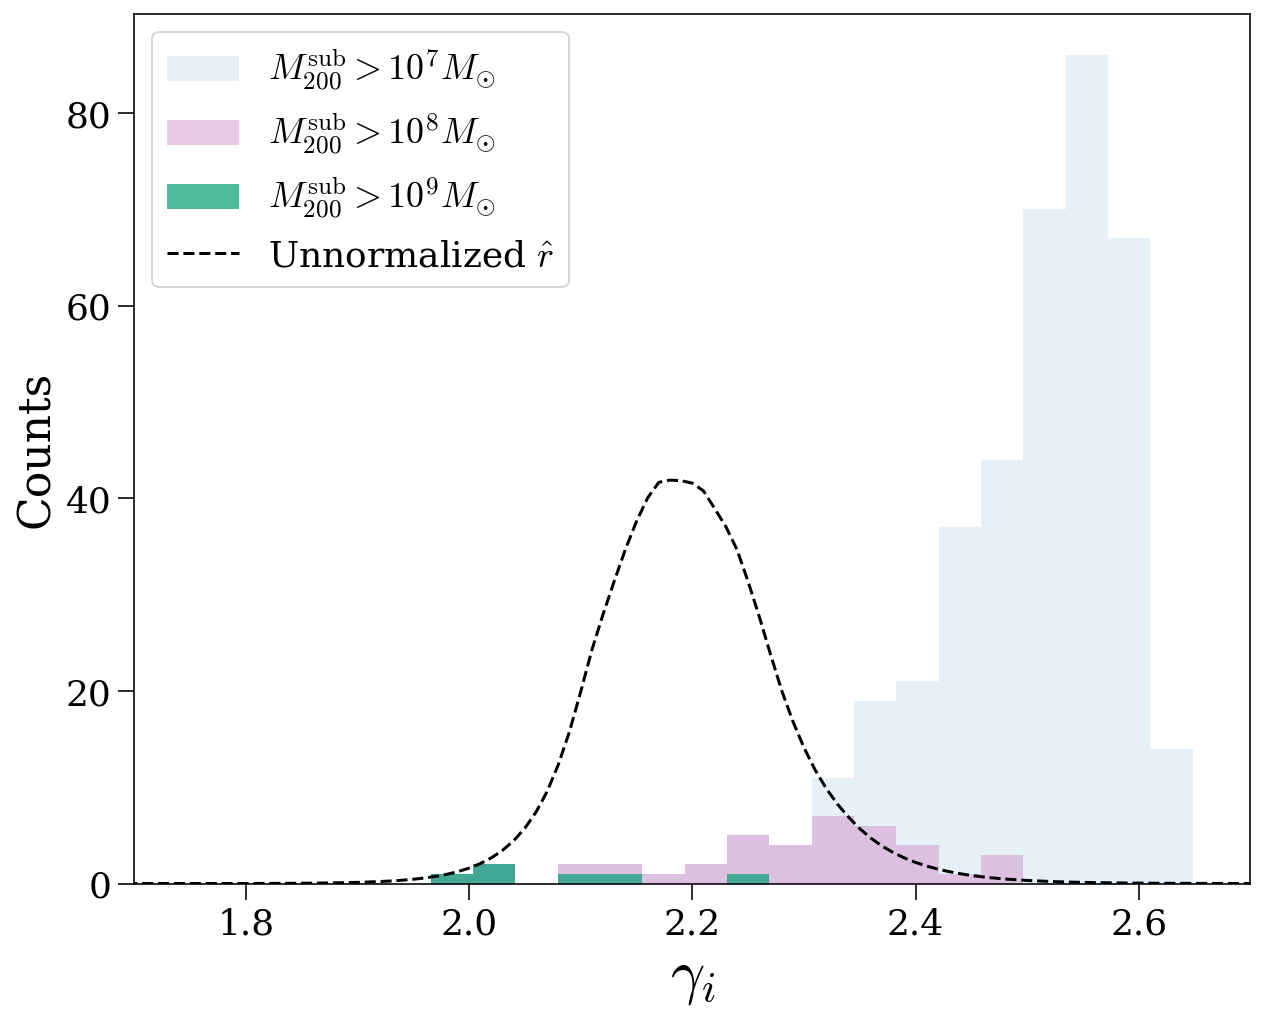

In [27]:
slope_fit_bins = np.linspace(1.7, 2.8, num=30)

plt.figure(figsize=(10, 8))
plt.hist(slopes_rmo[msubs > 1e7], bins=slope_fit_bins, histtype='stepfilled', alpha=0.1, color=colors[0], label=r'$M_{200}^{\mathrm{sub}} > 10^7 M_{\odot}$') 
plt.hist(slopes_rmo[msubs > 1e8], bins=slope_fit_bins, histtype='stepfilled', alpha=0.4, color=colors[1], label=r'$M_{200}^{\mathrm{sub}} > 10^8 M_{\odot}$')
plt.hist(slopes_rmo[msubs > 1e9], bins=slope_fit_bins, histtype='stepfilled', alpha=0.7, color=colors[2], label=r'$M_{200}^{\mathrm{sub}} > 10^9 M_{\odot}$')

plt.plot(gammas_test, 5*np.e**logps_single[:, 0], color='black', linestyle='--', label=r'Unnormalized $\hat{r}$')

plt.xlabel(r'$\gamma_i$', fontsize=30)
plt.ylabel('Counts')
plt.xlim(1.7, 2.7)
plt.legend(loc='upper left', fontsize=18)

#plt.savefig('../data/compare_rmoestimates_resnetpred_shear_dark.pdf')
print(len(msubs))

In [28]:
r_kappabars = np.linspace(0.08, 1, num=101)

# low mass example 
idx_single_lowm = np.where(msubs < 2e7)[0][0]

args_subhalo_lowm = lensarg[idx_single_lowm + 2]  
kappabars_rkappabar_lowm = kappabar_nfw(r_kappabars, args_subhalo_lowm['Rs'], args_subhalo_lowm['alpha_Rs'])
kappabars_rctr_lowm, sig_rctr_lowm, msub_lowm = get_kappabars_and_errors(args_subhalo_lowm, r_ctrs, x_grid, y_grid, 
                                                                         C_inv, kernel, deltapix)
rs_rmo_fit_lowm = compute_rmo_range(r_bins, sig_rctr_lowm/kappabars_rctr_lowm, 2)
slope_lowm = avg_densityslope(rs_rmo_fit_lowm, args_subhalo_lowm['Rs'], args_subhalo_lowm['alpha_Rs'])

# high mass example 
idx_single_highm = np.where((msubs > 1e9)*(msubs < 2e9))[0][0]

args_subhalo_highm = lensarg[idx_single_highm + 2]  
kappabars_rkappabar_highm = kappabar_nfw(r_kappabars, args_subhalo_highm['Rs'], args_subhalo_highm['alpha_Rs'])
kappabars_rctr_highm, sig_rctr_highm, msub_highm = get_kappabars_and_errors(args_subhalo_highm, r_ctrs, x_grid, y_grid, 
                                                                            C_inv, kernel, deltapix)
rs_rmo_fit_highm = compute_rmo_range(r_bins, sig_rctr_highm/kappabars_rctr_highm, 2)
slope_highm = avg_densityslope(rs_rmo_fit_highm, args_subhalo_highm['Rs'], args_subhalo_highm['alpha_Rs'])

print('low Msub = {:2e}'.format(msub_lowm))
print('high Msub = {:2e}'.format(msub_highm))

low Msub = 1.488604e+07
high Msub = 1.599722e+09


2.5532912906086924


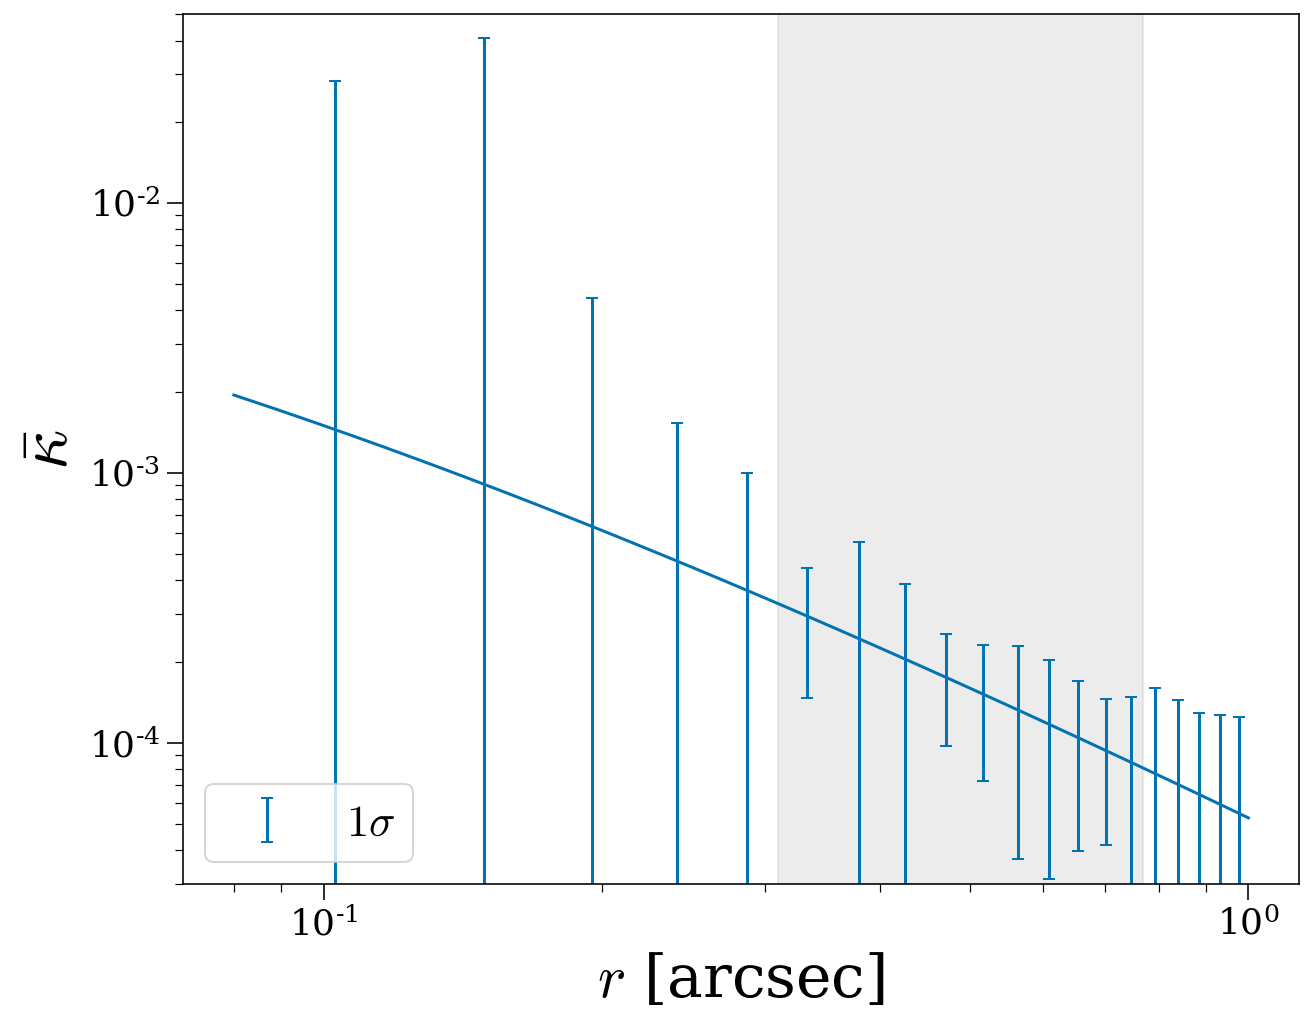

In [29]:
plt.figure(figsize=(10, 8))
plt.loglog(r_kappabars, kappabars_rkappabar_lowm, color=colors[0])
plt.errorbar(r_ctrs, kappabars_rctr_lowm, sig_rctr_lowm, fmt='none', capsize=3, color=colors[0], label=r'$1\sigma$')
plt.axvspan(np.min(rs_rmo_fit_lowm), np.max(rs_rmo_fit_lowm), color='gray', alpha=0.15)

plt.xlabel(r'$r$ [arcsec]', fontsize=30)
plt.ylabel(r'$\bar{\kappa}$', fontsize=35)
plt.ylim(3e-5, 5e-2)
plt.legend()

print(slope_lowm)
#plt.savefig('../data/sample_lowm_rmo_shear_dark.pdf')

2.13290929051558


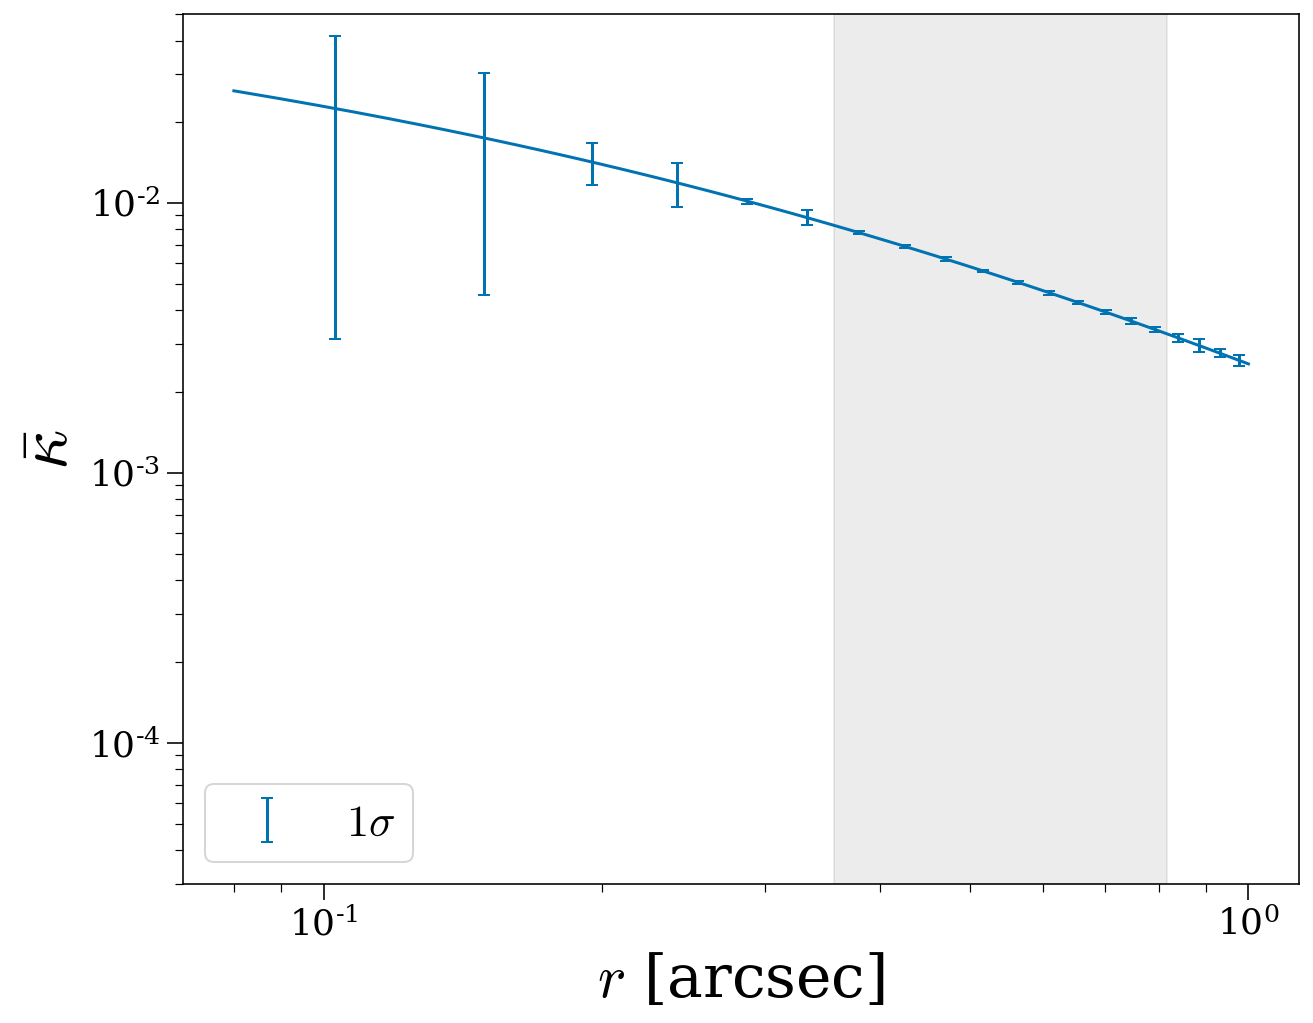

In [30]:
plt.figure(figsize=(10, 8))
plt.loglog(r_kappabars, kappabars_rkappabar_highm, color=colors[0])
plt.errorbar(r_ctrs, kappabars_rctr_highm, sig_rctr_highm, capsize=3, fmt='none', color=colors[0], label=r'$1\sigma$')
plt.axvspan(np.min(rs_rmo_fit_highm), np.max(rs_rmo_fit_highm), color='gray', alpha=0.15)

plt.xlabel(r'$r$ [arcsec]', fontsize=30)
plt.ylabel(r'$\bar{\kappa}$', fontsize=35)
plt.ylim(3e-5, 5e-2)
plt.legend()

print(slope_highm)
#plt.savefig('../data/sample_highm_rmo_shear_dark.pdf')